In [1]:
import nemo
import nemo.collections.nlp as nemo_nlp
from nemo.collections.nlp.data.datasets import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import SequenceClassifier

from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback
from nemo import logging

import os
import json
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2020-09-29 03:28:47 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


In [2]:
AMP_OPTIMIZATION_LEVEL = 'O1'
WORK_DIR = 'output/'
PRETRAINED_MODEL_NAME = 'bert-base-uncased' # 'megatron-bert-uncased', 'bert-large-uncased'
PRETRAINED_MODEL_CHECKPOINT = './checkpoint/bert/bert.pt'
PRETRAINED_MODEL_CONFIG = './checkpoint/bert/bert_config.json'
TRAIN_DATA_PATH = './data/train.tsv'
TEST_DATA_PATH = './data/test.tsv'

MAX_SEQ_LEN = 256
DROPOUT_RATE = .3
BATCH_SIZE = 32

n_epochs = 3
lr_warmup_proportion = 0.1
lr = 3e-5
weight_decay = 0.01

In [3]:
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level=AMP_OPTIMIZATION_LEVEL)

In [4]:
model = nemo_nlp.nm.trainables.get_pretrained_lm_model(
    pretrained_model_name=PRETRAINED_MODEL_NAME,
    config=PRETRAINED_MODEL_CONFIG,
    checkpoint=PRETRAINED_MODEL_CHECKPOINT
)
tokenizer = nemo.collections.nlp.data.tokenizers.get_tokenizer(
    tokenizer_name='nemobert',
    pretrained_model_name=PRETRAINED_MODEL_NAME,
    do_lower_case=True
)
classifier = SequenceClassifier(    
    hidden_size=model.hidden_size,
    num_classes=2,
    dropout=DROPOUT_RATE,
    num_layers=2,
    log_softmax=False,
)
loss_func = CrossEntropyLossNM()
train_data_layer = BertTextClassificationDataLayer(
    tokenizer=tokenizer,
    input_file=TRAIN_DATA_PATH,
    max_seq_length=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
    shuffle=True,
    use_cache=True
)
eval_data_layer = BertTextClassificationDataLayer(
    tokenizer=tokenizer,
    input_file=TEST_DATA_PATH,
    max_seq_length=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
    shuffle=False,
    use_cache=False
)

[NeMo I 2020-09-29 03:28:52 common_utils:85] bert-base-uncased model restored from ./checkpoint/bert/bert.pt
[NeMo I 2020-09-29 03:28:52 bert_tokenizer:78] Deriving bert model type from pretrained model name.
[NeMo I 2020-09-29 03:28:53 text_classification_dataset:217] features restored from ./data/cached_train_BertTokenizer_256_30522
[NeMo I 2020-09-29 03:28:53 text_classification_dataset:82] ./data/test.tsv: 20000
[NeMo I 2020-09-29 03:30:41 data_preprocessing:250] Min: 21 |                  Max: 298 |                  Mean: 102.33595 |                  Median: 91.0
[NeMo I 2020-09-29 03:30:41 data_preprocessing:252] 75 percentile: 139.0
[NeMo I 2020-09-29 03:30:41 data_preprocessing:253] 99 percentile: 237.0
[NeMo I 2020-09-29 03:30:41 text_classification_dataset:118] 35 out of 20000                         sentences with more than 256 subtokens.
[NeMo I 2020-09-29 03:30:41 text_classification_dataset:175] *** Example ***
[NeMo I 2020-09-29 03:30:41 text_classification_dataset:176] 

In [5]:
model.num_weights, model.hidden_size

(109482240, 768)

In [6]:
train_data = train_data_layer()
train_hidden_states = model(input_ids=train_data.input_ids, token_type_ids=train_data.input_type_ids, attention_mask=train_data.input_mask)
train_logits = classifier(hidden_states=train_hidden_states)
loss = loss_func(logits=train_logits, labels=train_data.labels)
# If you're training on multiple GPUs, this should be
# len(train_data_layer) // (batch_size * batches_per_step * num_gpus)
train_steps_per_epoch = len(train_data_layer) // BATCH_SIZE

eval_data = eval_data_layer()
eval_hidden_states = model(input_ids=eval_data.input_ids, token_type_ids=eval_data.input_type_ids, attention_mask=eval_data.input_mask)
eval_logits = classifier(hidden_states=eval_hidden_states)

In [7]:
train_callback = nemo.core.SimpleLossLoggerCallback(
    tensors=[loss],
    print_func=lambda x: logging.info("Loss: {:.3f}".format(x[0].item())),
    get_tb_values=lambda x: [["loss", x[0]]],
    step_freq=train_steps_per_epoch,
    tb_writer=nf.tb_writer,
)

# Callback to evaluate the model
eval_callback = nemo.core.EvaluatorCallback(
        eval_tensors=[eval_logits, eval_data.labels],
        user_iter_callback=lambda x, y: eval_iter_callback(x, y, eval_data_layer),
        user_epochs_done_callback=lambda x: eval_epochs_done_callback(x, f'{nf.work_dir}/graphs'),
        tb_writer=nf.tb_writer,
        eval_step=train_steps_per_epoch,
    )

[NeMo W 2020-09-29 03:30:45 deprecated:66] Function ``__init__`` is deprecated. It is going to be removed in the 0.12 version. The callback section of NeMo has been updated.


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-09-29 03:33:50 deprecated_callbacks:195] Starting .....


[NeMo W 2020-09-29 03:33:50 deprecated:66] Function ``epoch_num`` is deprecated. It is going to be removed in the 0.12 version. epoch_num has been deprecated in favour of epoch.


[NeMo I 2020-09-29 03:33:50 deprecated_callbacks:207] Starting epoch 0
[NeMo I 2020-09-29 03:33:51 deprecated_callbacks:232] Step: 0
[NeMo I 2020-09-29 03:33:51 <ipython-input-7-77fd1981e82e>:3] Loss: 0.701
[NeMo I 2020-09-29 03:33:51 deprecated_callbacks:247] Step time: 0.6725730895996094 seconds
[NeMo I 2020-09-29 03:33:51 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2020-09-29 03:34:40 text_classification_callback:57] Accuracy: 0.5143
[NeMo I 2020-09-29 03:34:40 text_classification_callback:64] Sampled preds: [0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1]
[NeMo I 2020-09-29 03:34:40 text_classification_callback:65] Sampled labels: [0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1]
[NeMo I 2020-09-29 03:34:40 callback_utils:92] Confusion matrix:
    [[2335 7739]
     [1975 7951]]
[NeMo I 2020-09-29 03:34:41 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.5418    0.2318    0.3247     10074
      

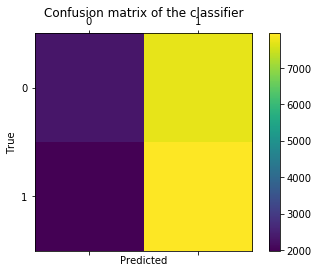

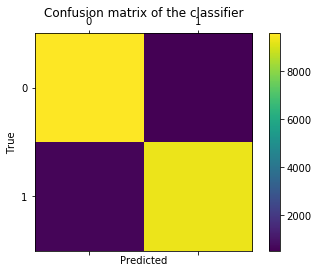

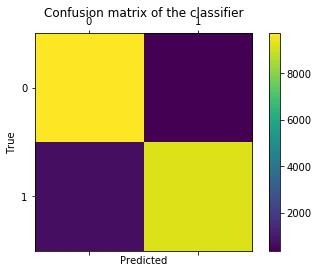

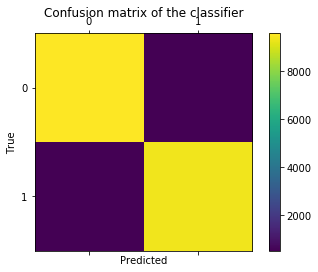

In [9]:
lr_policy_fn = get_lr_policy("WarmupAnnealing", total_steps=n_epochs * train_steps_per_epoch, warmup_ratio=lr_warmup_proportion
)
nf.train(
    tensors_to_optimize=[loss],
    callbacks=[train_callback, eval_callback],
    lr_policy=lr_policy_fn,
    optimizer="adam_w",
    optimization_params={"num_epochs": n_epochs, "lr": lr, "weight_decay": weight_decay},
)